In [30]:
# Collection of python functions to help with analysis of nextGEMS data
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import (
    CloughTocher2DInterpolator,
    LinearNDInterpolator,
    NearestNDInterpolator,
)
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy.spatial import cKDTree
import numpy as np
from pyproj import CRS, Transformer

g = pyproj.Geod(ellps="WGS84")

In [2]:
import xarray as xr
import numpy as np
import intake

eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

model = 'ifs-fesom2-sr'
expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
version = 'v20240304'    #
realm='atmos'  # 'ocean' , 'land', 'atmos'
gridspec = 'native' # 'native', 'gr025'

cat_data_repent=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
print(list(cat_data))

# ds = cat_data['2D_daily_avg'].to_dask()
# ds

['2D_daily_avg', '2D_daily_max', '2D_daily_min', '2D_monthly_avg', '2D_monthly_max', '2D_monthly_min', '3D_daily_avg', '3D_monthly_avg', '3D_6hourly', '2D_6hourly_accumulated', '2D_6hourly_instant']


In [3]:
ds_present = cat_data['2D_daily_avg'].to_dask()
ds_present

/work/ab0995/a270088/mambaforge/envs/iccp/lib/python3.11/site-packages/zarr/core/metadata/v2.py:190: ZarrUserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, ZarrUserWarning, stacklevel=1)


<xarray.Dataset> Size: 54TB
Dimensions:    (time: 23741, value: 6599680)
Coordinates:
  * time       (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31...
    lat        (value) float64 53MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon        (value) float64 53MB dask.array<chunksize=(6599680,), meta=np.ndarray>
Dimensions without coordinates: value
Data variables: (12/43)
    cprate     (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    erate      (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m10u       (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m10v       (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m2d        (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m2sh       (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnlwrfcs  (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnswrf    (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnswrfcs  (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtsfr      (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    tprate     (time, value) float64 1TB dask.array<chunksize=(2, 6599680), meta=np.ndarray>
Attributes: (12/36)
    edition:               2
    centre:                ecmf
    centreDescription:     European Centre for Medium-Range Weather Forecasts
    subCentre:             0
    history:               🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan...
    Conventions:           CF-1.7 CMIP-6.2
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

In [4]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
dask.config.set({'temporary_directory': '/scratch/a/a270088/dask/'})
# client = Client(n_workers=5, threads_per_worker=1, memory_limit='50GB')
client = Client(n_workers=20, threads_per_worker=1, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:44587' processes=20 threads=20, memory=186.26 GiB>

In [6]:
%%time
temp_std = ds_present['mean2t'].sel(time=slice('1970','1979')).std(dim='time').compute()


CPU times: user 29.9 s, sys: 3.66 s, total: 33.5 s
Wall time: 2min 20s


In [8]:
lon = ds_present.lon.values
lat = ds_present.lat.values

In [9]:
left = 120
right = 140
bottom = 30
top = 45

In [10]:
region = (lon < right) & (lon>left) & (lat > bottom) & (lat < top)

In [11]:
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

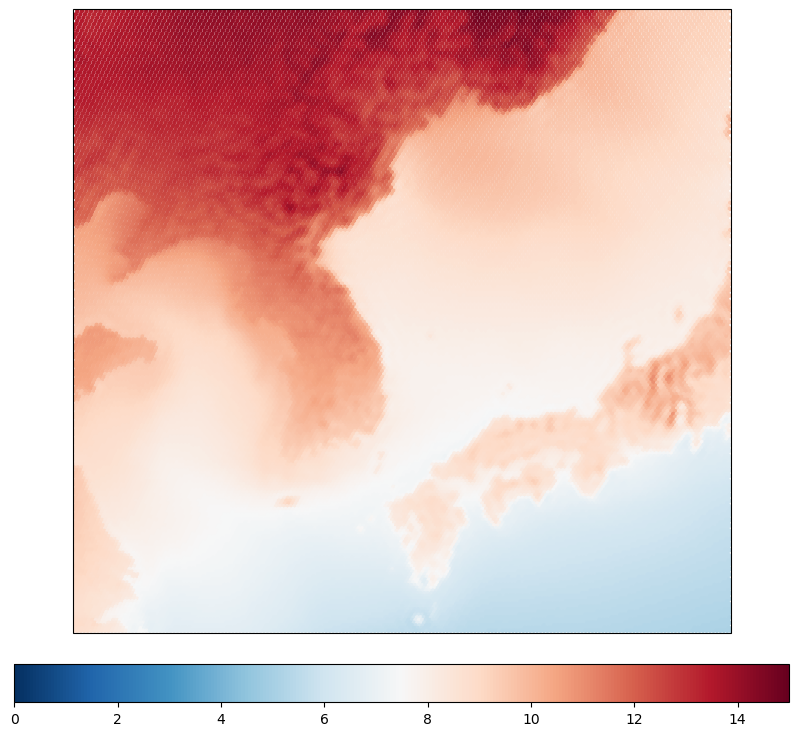

In [12]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
# ax.coastlines(resolution='10m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
mm = ax.scatter(lon[region], lat[region], s=5 , c=temp_std[region], 
           vmin=0, vmax=15,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
plt.colorbar(mm, orientation='horizontal', pad=0.04)

In [13]:
cat_data_future=eerie_cat['dkrz.disk.model-output'][model]["highres-future-ssp245"][version][realm][gridspec]
print(list(cat_data_future))

['2D_daily_avg', '2D_daily_max', '2D_daily_min', '2D_monthly_avg', '2D_monthly_max', '2D_monthly_min', '3D_daily_avg', '3D_monthly_avg']


In [14]:
ds_future = cat_data_future['2D_daily_avg'].to_dask()

/work/ab0995/a270088/mambaforge/envs/iccp/lib/python3.11/site-packages/zarr/core/metadata/v2.py:190: ZarrUserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, ZarrUserWarning, stacklevel=1)


In [15]:
temp_std_future = ds_future['mean2t'].sel(time=slice('2040','2050')).std(dim='time').compute()

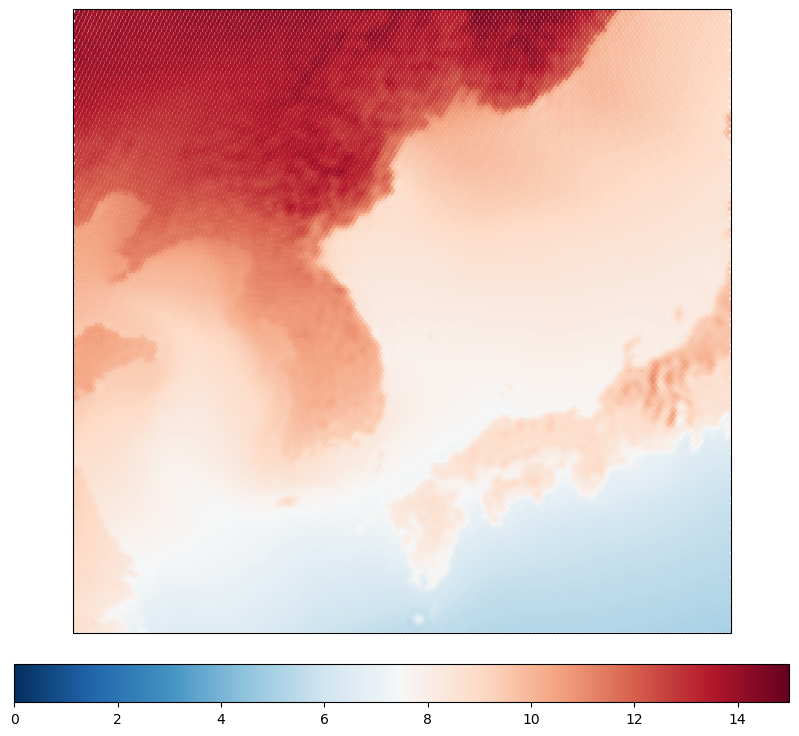

In [16]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
# ax.coastlines(resolution='10m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
mm = ax.scatter(lon[region], lat[region], s=5 , c=temp_std_future[region], 
           vmin=0, vmax=15,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
plt.colorbar(mm, orientation='horizontal', pad=0.04)

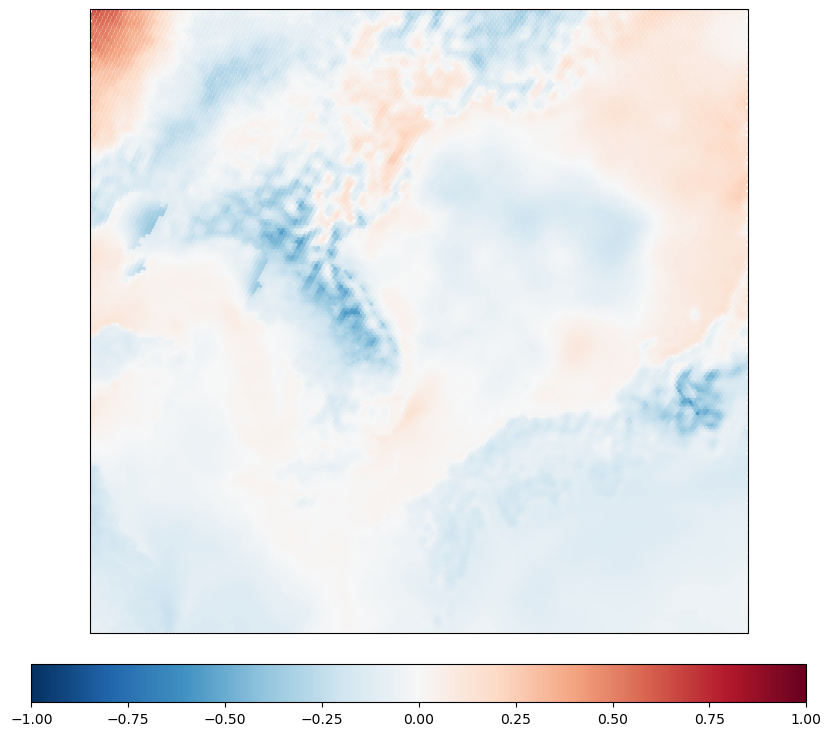

In [19]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
# ax.coastlines(resolution='10m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
mm = ax.scatter(lon[region], lat[region], s=5 , c=temp_std_future[region]-temp_std[region], 
           vmin=-1, vmax=1,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
plt.colorbar(mm, orientation='horizontal', pad=0.04)

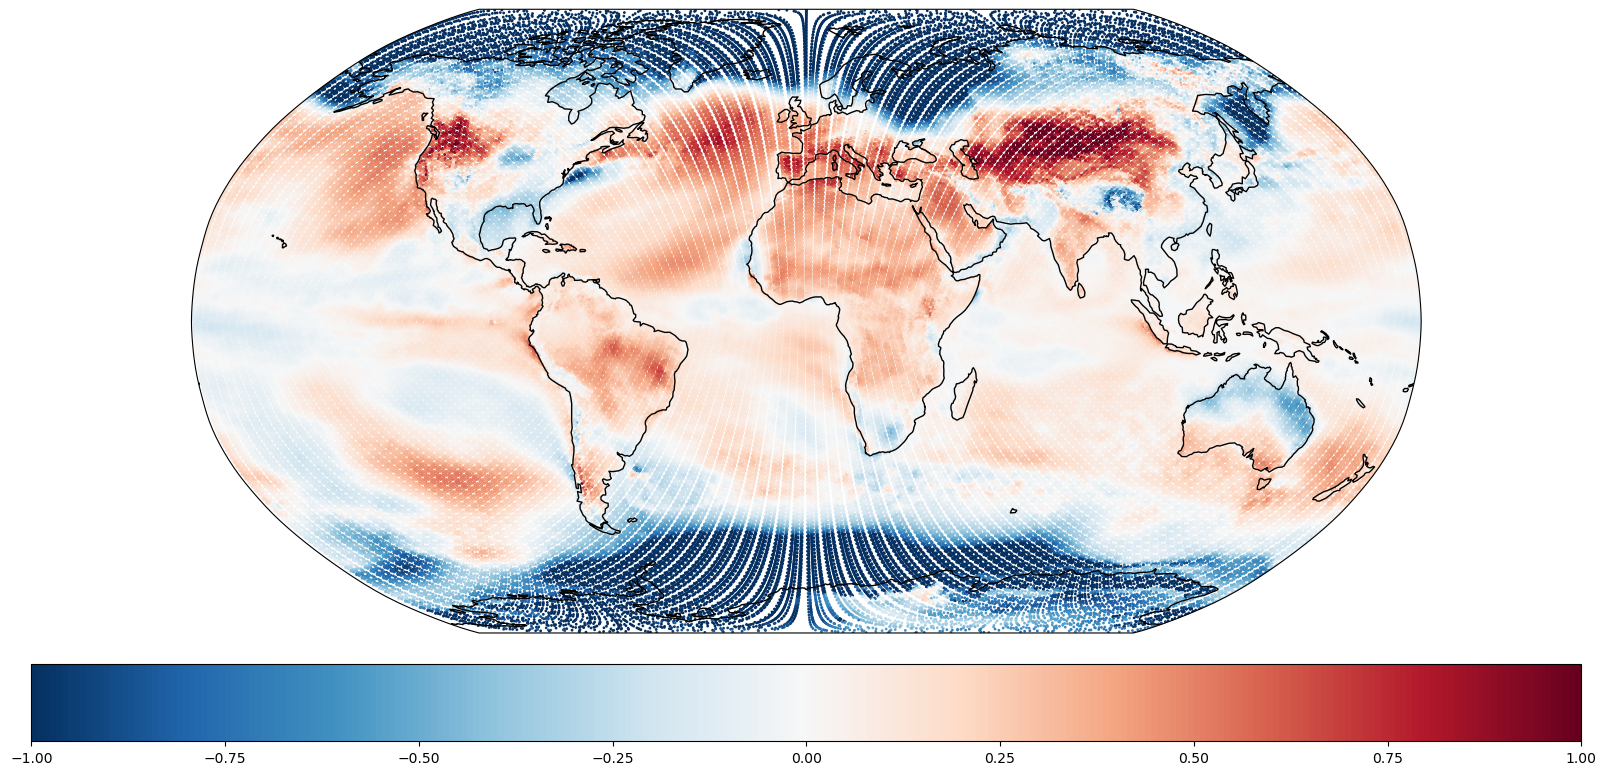

In [27]:
sstep = 30
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
mm = ax.scatter(lon[::sstep], lat[::sstep], s=1 , c=temp_std_future[::sstep]-temp_std[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
plt.colorbar(mm, orientation='horizontal', pad=0.04)

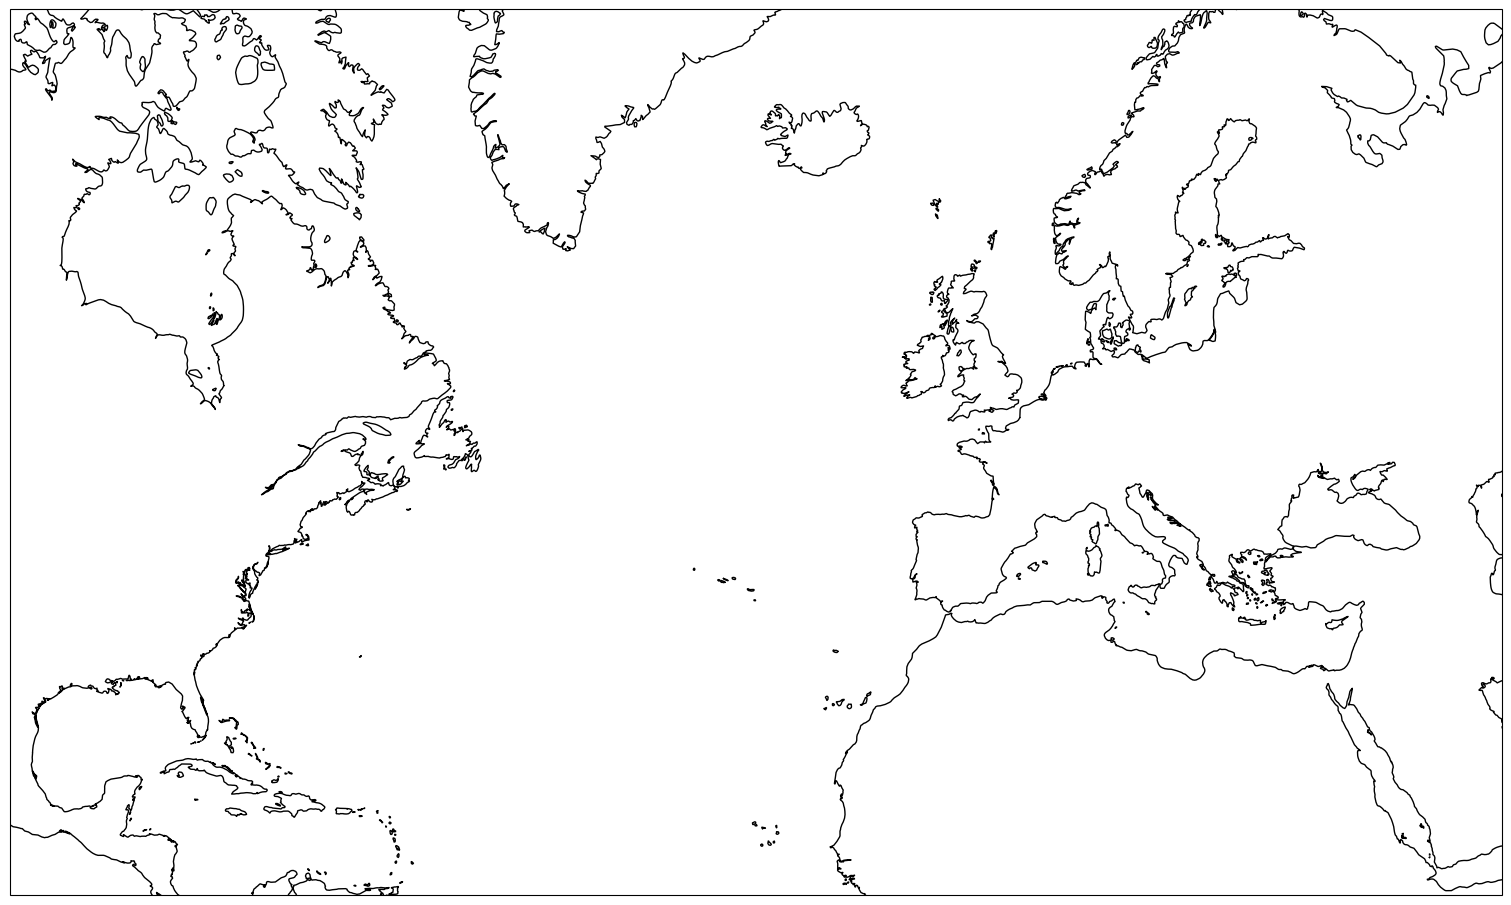

In [46]:
bbox = [-100, 50, 10, 70]
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines("50m")

In [47]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)), balanced_tree=False, compact_nodes=False)
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

def projected_grid_to_platecarree_pyproj(box, res, projection="World_Mercator", n_points=100):
    """
    Generate a grid of points in the desired projection and then convert the grid points back to 
    PlateCarree (longitude and latitude) space.

    This function creates additional points along the edges of the bounding box specified by the user.
    It then transforms those edge points to the projected coordinate space and calculates the bounding box in
    the projected coordinate space based on the transformed edge points. Finally, it creates a grid in the
    projected coordinate space using the calculated bounding box and converts the grid points back to the
    PlateCarree space.

    Parameters
    ----------
    box : list
        A list representing the bounding box in PlateCarree space, in the format [left,right,down,up].
    res : tuple or None
        A tuple (lonNumber, latNumber) representing the desired grid resolution in the projected
        coordinate space. If None, the default resolution (500, 500) is used.
    projection : str, optional
        The desired projection for the grid, specified as a string with the projection name or the EPSG code. 
        Default is 'World_Mercator'.
    n_points : int, optional
        The number of points to generate along each edge of the bounding box for approximating
        the corners of the projected image. Default is 100.

    Returns
    -------
    x : numpy.ndarray
        A 1D array of x coordinates in the projected coordinate space.
    y : numpy.ndarray
        A 1D array of y coordinates in the projected coordinate space.
    lon : numpy.ndarray
        A 2D array of longitude values in PlateCarree space corresponding to the generated grid points.
    lat : numpy.ndarray
        A 2D array of latitude values in PlateCarree space corresponding to the generated grid points.

    Notes
    -----
    The edge points are created by generating evenly spaced longitude and latitude values within the
    bounding box specified by the user. Four sets of points are created: the top edge, the bottom edge,
    the left edge, and the right edge of the bounding box. These points are then stacked together into a
    single array. Transforming these edge points to the target projection's coordinate space provides an 
    approximation of the edges of the projected image, which can be used to calculate a bounding box in 
    the projected coordinate space.
    """
    if isinstance(projection, str):
        projection_crs = CRS.from_string(projection)
    elif isinstance(projection, CRS):
        projection_crs = projection
    else:
        projection_crs = CRS.from_epsg(projection)
        
    # Define CRS for PlateCarree
    platecarree_crs = CRS.from_epsg(4326)

    # Create Transformer objects
    to_projection = Transformer.from_crs(platecarree_crs, projection_crs, always_xy=True)
    to_platecarree = Transformer.from_crs(projection_crs, platecarree_crs, always_xy=True)

    # Parse the bounding box and grid resolution
    left, right, down, up = box
    lonNumber, latNumber = res if res is not None else (500, 500)

    # Generate edge points in PlateCarree space
    lons = np.linspace(left, right, n_points)
    lats = np.linspace(down, up, n_points)
    edge_points_lon, edge_points_lat = np.meshgrid(
        np.hstack((lons, lons, np.repeat(left, n_points), np.repeat(right, n_points))),
        np.hstack((np.repeat(down, n_points), np.repeat(up, n_points), lats, lats)),
    )

    # Transform edge points to the target projection's coordinate space
    edge_points_x, edge_points_y = to_projection.transform(edge_points_lon, edge_points_lat)

    # Calculate the bounding box in the target projection's coordinate space
    xmin, xmax = np.min(edge_points_x), np.max(edge_points_x)
    ymin, ymax = np.min(edge_points_y), np.max(edge_points_y)

    # Create a grid in the target projection's coordinate space
    x = np.linspace(xmin, xmax, lonNumber)
    y = np.linspace(ymin, ymax, latNumber)
    x2d, y2d = np.meshgrid(x, y)

    # Convert the grid points back to PlateCarree space
    lon, lat = to_platecarree.transform(x2d, y2d)

    return x, y, lon, lat

In [48]:
x, y, lon2, lat2 = projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_Mercator", n_points=100)


In [49]:
distances, inds = create_indexes_and_distances(lon, lat, lon2, lat2, k=1, workers=10)


In [50]:
std_diff = temp_std_future-temp_std

In [51]:
data_sample = std_diff
# data_sample2 = data['2t'][1106,:]

radius_of_influence=10000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

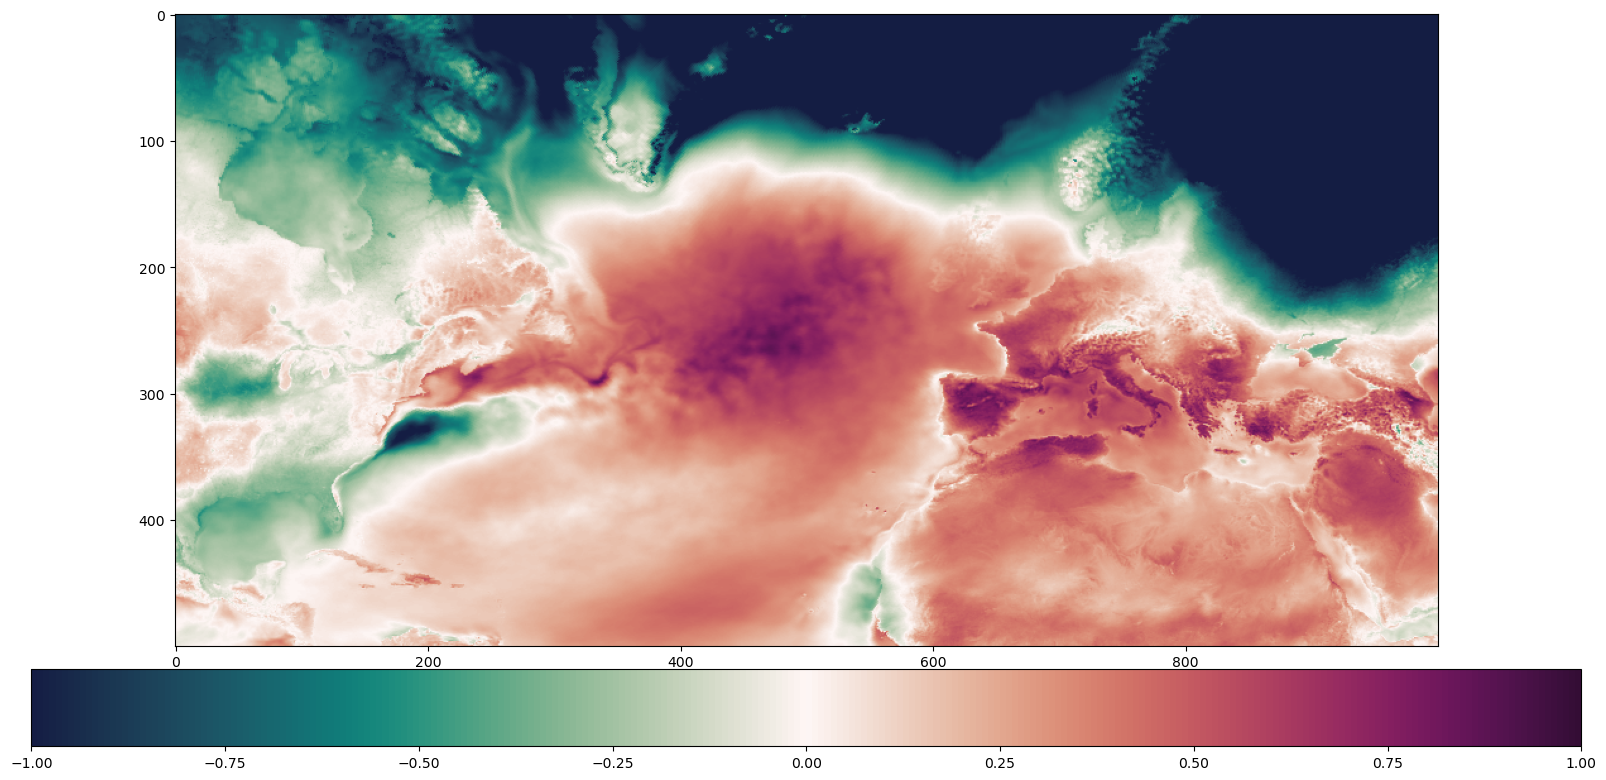

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(np.flipud(data_interpolated), vmin=-1, vmax=1, cmap=cmo.curl)
plt.colorbar(orientation='horizontal', pad=0.03)

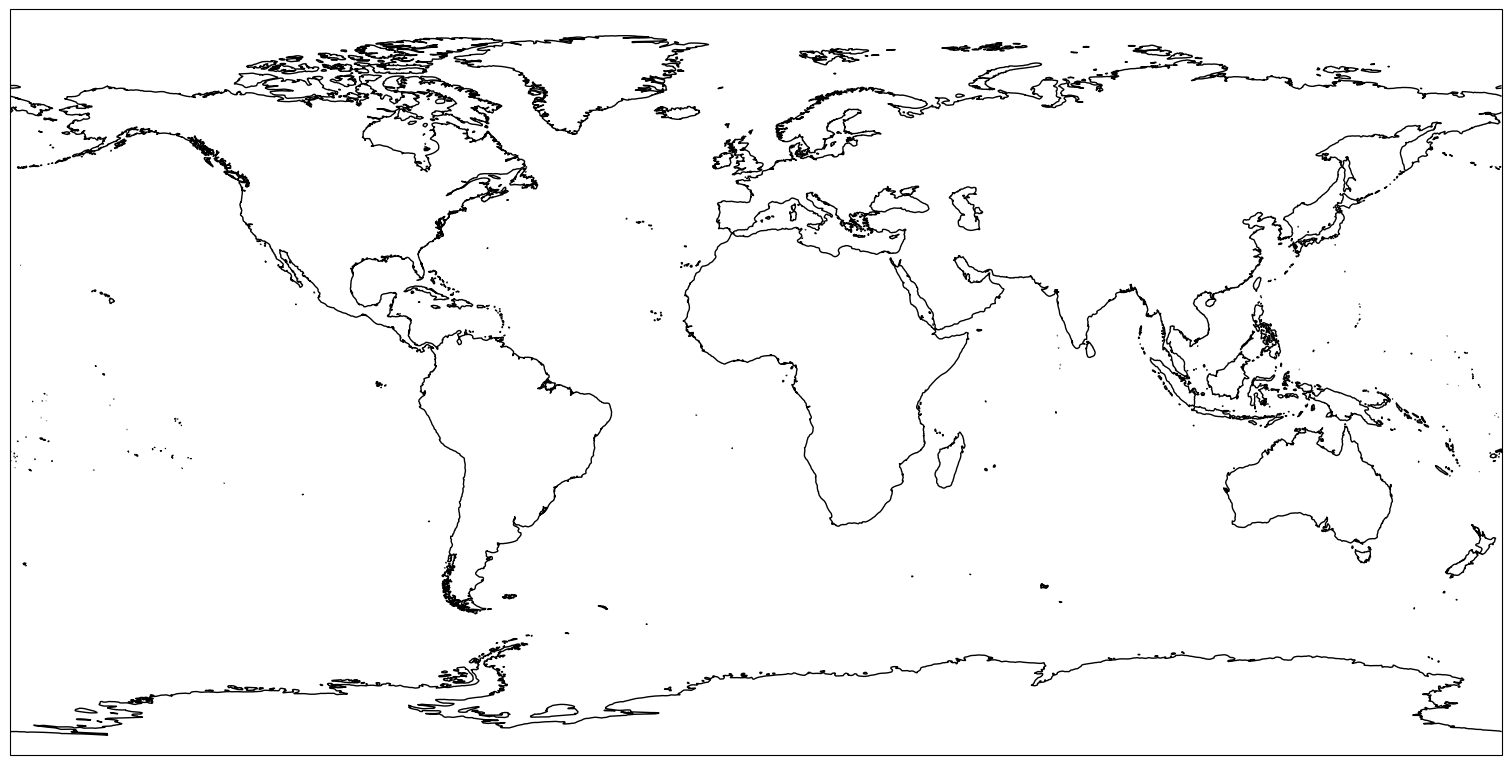

In [59]:
bbox = [-180, 180, -90, 90]
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.PlateCarree()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines("50m")

In [60]:
x, y, lon2, lat2 = projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_PlateCarree", n_points=100)


In [61]:
distances, inds = create_indexes_and_distances(lon, lat, lon2, lat2, k=1, workers=10)


In [62]:
data_sample = std_diff
# data_sample2 = data['2t'][1106,:]

radius_of_influence=10000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

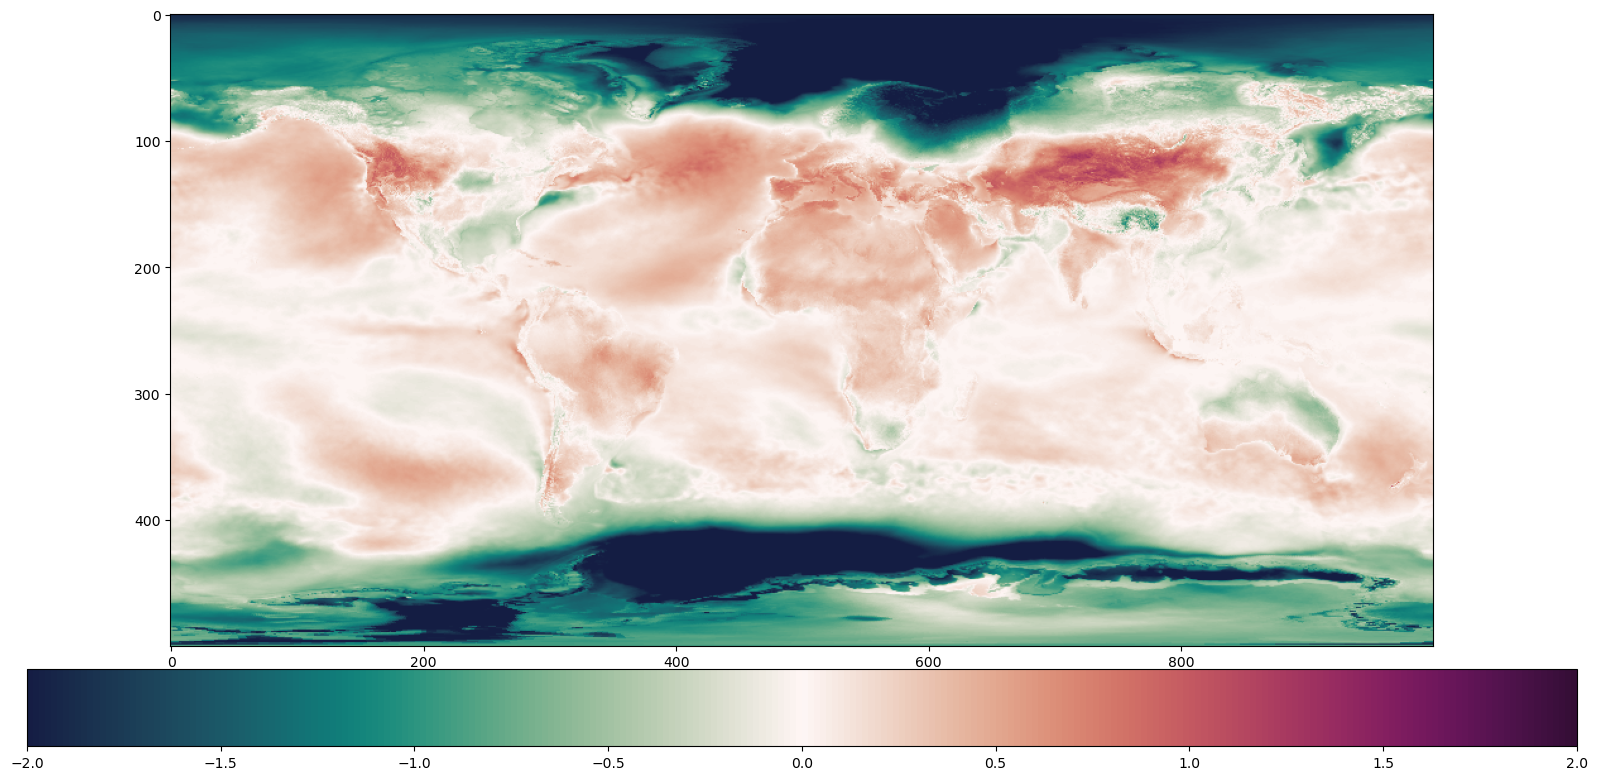

In [64]:
plt.figure(figsize=(20,10))
plt.imshow(np.flipud(data_interpolated), vmin=-2, vmax=2, cmap=cmo.curl)
plt.colorbar(orientation='horizontal', pad=0.03)